In [1]:
import os
import numpy as np
import networkx as nx
from itertools import combinations
from collections import OrderedDict, Counter
from sklearn.cluster import AgglomerativeClustering

In [2]:
dictMutantOrder=OrderedDict()
dictMutantOrder['Wild-type']=['wt','M470V']
dictMutantOrder['Lasso Elbow & TMD1']=['R117C','R117H','E92K','E56K','G85E','I148T','R74W','R75Q','P67L','E60K','M1101K']
dictMutantOrder['R-Domain']=['I37R','R31C','D836Y','E826K']
dictMutantOrder['Pore Architecture']=['L927P','R347H','R347P']
dictMutantOrder['Lower-TM8']=['S945L','M952T']
dictMutantOrder['Pore Conductance']=['D1152H']
dictMutantOrder['ATP-binding']=['Q1291F','Q1291H','G551D','G551S','S549R','D529N','F575Y']
dictMutantOrder['NBD Integrity']=['V520F','R560T','D513G','dF508','R1066C','R1066H']
dictMutantOrder['Outer-NBD1']=['A455E','D614G','L467P']
dictMutantOrder['Drug Resistance']=['N1303K']
dictMutantOrder['Outer-NBD2']=['S1235R']
#flattenedMutantOrder = [j for i in mutantOrder for j in i]
flattenedMutantOrder=[]
for k in dictMutantOrder:
    flattenedMutantOrder.extend( dictMutantOrder[k] )

In [3]:
polarRes={'SER','THR','ASN','GLN','ASP','GLU','TYR','TRP','ARG','LYS','HIS','HSD','HSE'}
def match_name(s):
    for x in polarRes:
        if x in s:
            return True
    return False

def parse_contact_pairs(fileName, minWeight=0.0, bPolarOnly=False):
    G = nx.Graph()
    G.source=fileName
    with open( fileName, 'r' ) as fp:
        for line in fp:
            l=line.split() ; w = float(l[2])
            if bPolarOnly:
                if not match_name(l[1]):
                    continue
            if w < minWeight:
                continue
            ligID  = l[0]
            #protID = l[1]
            segID, resName, resID = l[1].split(":")
            # = = Deal with mutants here for now.
            protID = "%s:%s" % (segID, resID)                
            G.add_edge(ligID,protID, weight=w)
            G.nodes[ligID]['resType']='solvent'
            G.nodes[protID]['resType']='solute'
            G.nodes[ligID]['source']=fileName
            G.nodes[protID]['source']=fileName
            
    G.solventIDs  = [ x for x,y in G.nodes(data='resType') if y == 'solvent']
    G.numSolvents = len(G.solventIDs)    
    for k in G.solventIDs:
        G.nodes[k]['meanWeight'] = np.mean( [ G.edges[x]['weight'] for x in G.edges(k)] )

    G.soluteIDs   = [ x for x,y in G.nodes(data='resType') if y == 'solute']
    G.numSolutes  = len(G.soluteIDs)            
    return G

In [4]:
def map_solvent_contacts(GFrom, GTo):
    lFrom = GFrom.solventIDs ; nFrom=len(lFrom)
    lTo = GTo.solventIDs ; nTo=len(lTo)
    matOverlap=np.zeros( (nFrom, nTo) )
    #matOverlap={} ; matOverlapRev={}
    for i, a in enumerate(lFrom):
        setAA = {aa for aa in GFrom[a]}
        for j,b in enumerate(lTo):
            setBB = {bb for bb in GTo[b]}
            matOverlap[i,j] = calc_Jaccard(setAA,setBB)
            #matOverlap[a,b]=1.0*len(setAA.intersection(setBB))/np.max((len(setAA),len(setBB)))
            #matOverlapRev[b,a]=1.0*len(setAA.intersection(setBB))/np.max((len(setAA),len(setBB)))
            #print(i,j,setAA.intersection(setBB), len(setAA), len(setAA.intersection(setBB)), len(setBB) )
    return matOverlap

In [5]:
def renumber_clusterIDs_by_size(c):

    counter = Counter(c)
    mapping={}
    for i,x in enumerate(counter.most_common()):
        #print(i,x)
        mapping[x[0]] = i
    #mapping = {v: k for k, v in mapping.items()}
    return np.array([mapping[x] for x in c])

In [6]:
def get_files_from_list(fileName, order=None):
    out=[]
    with open(fileName,'r') as fp:
        for line in fp:
            l=line.split()
            out.append(l[0])   
    if order is not None:
        outB=[] ; bAssigned=np.repeat(False, len(out))
        for m in order:
            for i,x in enumerate(out):
                if m in x:
                    outB.append( x )
                    bAssigned[i]=True
        for i,x in enumerate(out):
            if not bAssigned[i]:
                print("= = Note: %s has not been matched to the mutant order" % x)
                outB.append( x )
        print(" = = reordered file list, debuging lengths before and after: %i -> %i" % (len(out), len(outB)) )
        if len(out) != len(outB):
            print( out )
            print( outB )
        return outB
    else:
        return out

In [7]:
def filter_mutant_names(stringList, searchList):
    out=[]
    for i in stringList:
        bFound=False
        for j in searchList:
            if j in i:
                bFound=True
                out.append(j)
                break
        if not bFound:
            print(" = = WARNING: %s is not in mutant list." % i)
    return out

In [8]:
def calc_Jaccard(sA, sB):
    return len(set.intersection(sA,sB))/len(set.union(sA,sB))

In [9]:
def get_neighbours(g, x):
    return set(nx.neighbors(g,x))

In [10]:
def convert_to_selection(s):
    selText="protein and resid"
    for x in s:
        resid=x.split(":")[-1]
        selText=selText+" "+resid
    return selText

In [11]:
allele='wt'
temperature='310K'
pairFile='contactPairs_CL.txt'

In [12]:
minWeight=0.5
bPolarOnly=False
listG = []
#for repl in range(1,4):
#    fileName = './trajectories/%s/%s/%i/%s' % (allele, temperature, repl, pairFile)
numSolvents = 0
offsetSolvents = []
fileNames = get_files_from_list('./list_contactPairs_SOL.txt',order=flattenedMutantOrder)
for f in fileNames:
    tempG = parse_contact_pairs( f, minWeight, bPolarOnly)
    listG.append( tempG )
    offsetSolvents.append( numSolvents )
    numSolvents+= tempG.numSolvents
numG = len(listG)
offsetSolvents.append( numSolvents )

mutantNames = filter_mutant_names(fileNames, flattenedMutantOrder)
for i in range(numG):
    listG[i].allele=mutantNames[i]
print(" = = Number of graphs read:", numG )
print(" = = Total number of solvent molecules identified:", numSolvents )
print(" = = Offsets:", offsetSolvents )

FileNotFoundError: [Errno 2] No such file or directory: './list_contactPairs_SOL.txt'

In [13]:
# = = = Report basic connectivity
for G in listG:
    print("%s contains %i solute residues and %i solvent residues." % (G.source, G.numSolutes, G.numSolvents))
    print("    ...Solute node degrees:", end=' ')
    for k in G.soluteIDs:
        print( len(G[k]), end=' ')
    print('')
    print("    ...Solvent node degrees:", end=' ')
    for k in G.solventIDs:
        print( len(G[k]), end=' ')
    print('')

./trajectories/wt/310K/1/contactPairs_SOL.txt contains 56 solute residues and 10 solvent residues.
    ...Solute node degrees: 2 1 2 2 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 2 1 1 2 2 2 2 2 2 1 2 2 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 
    ...Solvent node degrees: 4 9 7 6 10 9 6 9 7 6 
./trajectories/wt/310K/2/contactPairs_SOL.txt contains 32 solute residues and 8 solvent residues.
    ...Solute node degrees: 2 1 1 1 2 2 1 1 1 3 2 2 3 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
    ...Solvent node degrees: 7 5 4 6 8 9 3 1 
./trajectories/wt/310K/3/contactPairs_SOL.txt contains 28 solute residues and 6 solvent residues.
    ...Solute node degrees: 1 2 1 2 1 1 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
    ...Solvent node degrees: 7 6 6 5 5 5 
./trajectories/M470V/310K/1/contactPairs_SOL.txt contains 61 solute residues and 11 solvent residues.
    ...Solute node degrees: 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 2 3 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1

In [14]:
# = = Construct solventID lists for overall map
hostSolvents=[]
nameSolvents=[]
for i in range(numG):
    hostSolvents.extend(np.repeat(i,listG[i].numSolvents))
    nameSolvents.extend( listG[i].solventIDs )

In [15]:
# = = Going to a giant map of M[G1,G2][key1,key2], can use a numpy array for this, although 
mapIntersects = np.zeros( (numSolvents,numSolvents) )
for i,j in combinations(range(numG),2):
    G1=listG[i] ; G2=listG[j] ;
    submap = map_solvent_contacts(G1, G2)
    ii = offsetSolvents*i
    jj = offsetSolvents*j
    mapIntersects[offsetSolvents[i]:offsetSolvents[i+1],offsetSolvents[j]:offsetSolvents[j+1]] = submap
    #mapNodes[j,i] = mapNodes[i,j].T
    #maxIntersects[i,j] = maxIntersects[j,i] = np.max(mapNodes[i,j])
    #countIntersects[i,j] = countIntersects[j,i] = len(mapNodes[i,j]>0)

In [16]:
# from sklearn.neighbors import DistanceMetric
# dist = DistanceMetric.get_metric('jaccard')
# This one is useless too.
#dist.pairwise(e1,e2)

In [17]:
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker


sizeFigure=(11,8)

In [79]:
listMatDiff=[]
#listDistThres=[0.0,0.5,0.8,1.0]
listDistThres=[1.0]
listClustCounts=[]
listClustIDs=[]
listClustGraph=[]
numList=len(listDistThres)
nRow=1 ; nCol=1
for distThres in listDistThres:
    clust = AgglomerativeClustering(n_clusters=None, affinity='precomputed', 
                                    linkage='complete', distance_threshold=distThres)
    clust.fit(1.0-mapIntersects)
    clustIDs = renumber_clusterIDs_by_size(clust.labels_)
    numClust = clust.n_clusters_

    clustContacts=[]
    clustCounts=[]
    for i in range( numClust ):
        indices = np.where( clustIDs == i )[0]
        nCount=len(indices)
        clustCounts.append(nCount)
        if nCount>1:
            neighbourList=[]
            for j in indices:
                neighbourList.append( get_neighbours( listG[hostSolvents[j]], nameSolvents[j] ) )
            union = neighbourList.pop().union(*neighbourList)
        else:
            union = get_neighbours( listG[hostSolvents[indices[0]]], nameSolvents[indices[0]] )
        clustContacts.append(union)
            
    matDiff=np.ones( (numClust,numClust) )
    for i,j in combinations( range(numClust),2):
        matDiff[i,j] = matDiff[j,i] = calc_Jaccard(clustContacts[i],clustContacts[j])   
        
    clustGraph = nx.Graph()
    for n, c in enumerate(clustCounts):
        clustGraph.add_node(n, size=c)
    for i,j in combinations( range(numClust),2):
        if matDiff[i,j]>0:
            clustGraph.add_edge(i,j,weight=matDiff[i,j])
              
    listMatDiff.append( matDiff )
    listClustCounts.append(clustCounts)
    listClustIDs.append(clustIDs)
    listClustGraph.append(clustGraph)


In [80]:
for i in range(numList):
    nDuplicates=0 ; j=0
    for a,b in zip(offsetSolvents[:-1],offsetSolvents[1:]):
        print( "Simulation %s water IDs:" % fileNames[j], np.sort(listClustIDs[i][a:b]) )
        if b-a > len( np.unique(listClustIDs[i][a:b]) ):
            nDuplicates+=1
        j+=1
    if nDuplicates > 0:
        print( "= = Note: Threshold %g leads to %i simulations that assign multiple waters to the same cluster." % (listDistThres[i], nDuplicates) )
    else:
        print( "= = Note: Threshold %g duplicate check assignment passed." % (listDistThres[i])) 

Simulation ./trajectories/wt/310K/1/contactPairs_SOL.txt water IDs: [ 0  1  2  3  5  8 10 12 17 30]
Simulation ./trajectories/wt/310K/2/contactPairs_SOL.txt water IDs: [ 0  1  4  9 11 15 18 31]
Simulation ./trajectories/wt/310K/3/contactPairs_SOL.txt water IDs: [ 0  1  2  4  6 36]
Simulation ./trajectories/M470V/310K/1/contactPairs_SOL.txt water IDs: [ 1  3  4  5  6 10 11 15 18 23 37]
Simulation ./trajectories/M470V/310K/2/contactPairs_SOL.txt water IDs: [ 0  1  2  3  4  5  7 13 17]
Simulation ./trajectories/M470V/310K/3/contactPairs_SOL.txt water IDs: [ 0  1  2  3  4  5  7 11 18 38]
Simulation ./trajectories/R117H/310K/1/contactPairs_SOL.txt water IDs: [ 0  1  2  3  4  5  8 11]
Simulation ./trajectories/R117H/310K/2/contactPairs_SOL.txt water IDs: [ 1  2  3  4  5  7 13 15 16 19 25 31 32]
Simulation ./trajectories/R117H/310K/3/contactPairs_SOL.txt water IDs: [ 0  1  2  3  4 12]
Simulation ./trajectories/E92K/310K/1/contactPairs_SOL.txt water IDs: [ 0  1  2  3  4  7 25]
Simulation ./tra

In [81]:
def merge_adjacent_labels( xCoords, labels):
    x=xCoords.copy() ; l=labels.copy()
    outX=[] ; outLabels=[]
    xPrev=[] ; labelPrev=""
    while len(l) > 0 :
        xThis = x.pop(0) ; labelThis = l.pop(0)
        if labelPrev == "":
            xPrev.append( xThis ) ; labelPrev=labelThis
        elif labelPrev != labelThis:
            outX.append( np.mean(xPrev) ) ; outLabels.append( labelPrev )
            xPrev = [ xThis ] ; labelPrev = labelThis
        else:
            xPrev.append( xThis )
    if xPrev != []:
        outX.append( np.mean(xPrev) ) ; outLabels.append( labelPrev )    
    return outX, outLabels

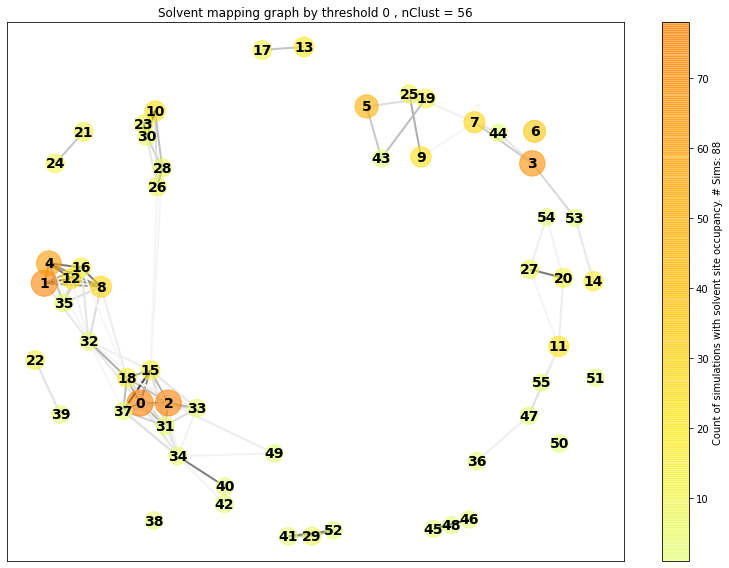

In [82]:
fig, axes = plt.subplots(nRow, nCol, figsize=sizeFigure)

for i in range(numList):
    jj = i % nCol ; ii = int(i / nCol)
    axThis = axes[ii,jj] if numList>1 else axes
    dictSizes   = nx.get_node_attributes(listClustGraph[i],'size') ; arrSizes = [ dictSizes[x] for x in listClustGraph[i].nodes  ] ; maxSize = np.max(arrSizes) ; minSize = 1
    dictWeights = nx.get_edge_attributes(listClustGraph[i],'weight')
    posInit = nx.kamada_kawai_layout(listClustGraph[i], weight='weight', scale=1, center=(0,0), dim=2)
    pos = nx.spring_layout(listClustGraph[i], pos=posInit, scale=1, center=(0,0), weight='weight', k=0.5)
    #pos = nx.spectral_layout(listClustGraph[i], weight='weight', scale=1, center=(0,0), dim=2)
    gg = nx.draw_networkx_nodes(listClustGraph[i], pos, ax=axThis, alpha=0.6,
                                node_size  = [ 5*x+300 for x in arrSizes  ],
                                node_color = [ x for x in arrSizes ],
                                cmap = cm.get_cmap('Wistia'), vmin=minSize, vmax=maxSize)
    plt.colorbar(gg, label='Count of simulations with solvent site occupancy. # Sims: %i' % numG, ax=axThis)    
    gg = nx.draw_networkx_edges(listClustGraph[i], pos, ax=axThis, 
                                edge_color = [ dictWeights[x] for x in listClustGraph[i].edges  ],
                                edge_cmap = cm.get_cmap('binary'), edge_vmin=0.0, edge_vmax=1.0, width=2)
    gg = nx.draw_networkx_labels(listClustGraph[i], pos, ax=axThis, font_size=14, font_weight='bold')                         

#    plt.colorbar(im, label='Mean contact occcupancy', ax=axThis)
    axThis.set_title('Solvent mapping graph by threshold %g , nClust = %i' % (1.0-listDistThres[i], len(listClustCounts[i])))
#plt.colorbar(im, ax=axThis)
plt.tight_layout()
plt.savefig('./solvent_mapping_cluster_graph.png')

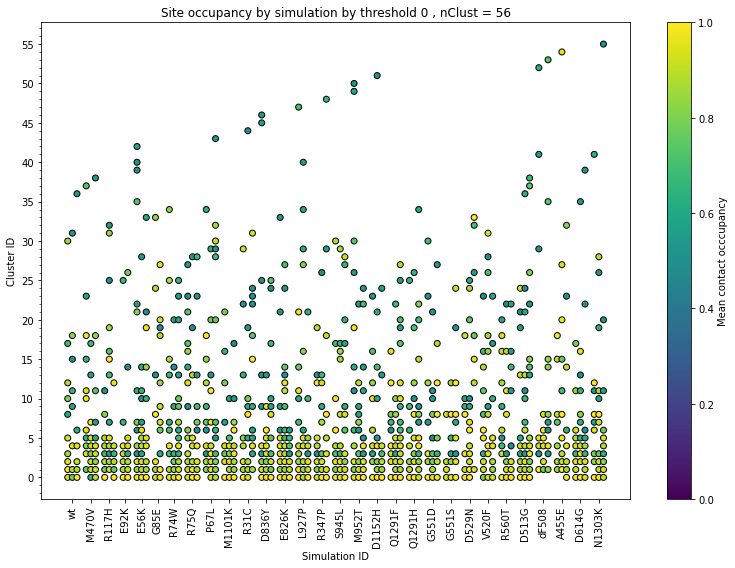

In [83]:
fig, axes = plt.subplots(nRow, nCol, figsize=sizeFigure)

mutantLabels = merge_adjacent_labels( [i for i in range(len(mutantNames))], mutantNames )
for i in range(numList):
    jj = i % nCol ; ii = int(i / nCol)
    axThis = axes[ii,jj] if numList>1 else axes
    j=0 ; listXVals=[] ; listYVals=[]  ; listWeights=[] ; listXLabels=[]; alleleName="" ; offsetX=0
    for a,b in zip(offsetSolvents[:-1],offsetSolvents[1:]):
        if alleleName != listG[j].allele and alleleName!="":
                offsetX+=1
        alleleName = listG[j].allele        
        listYVals.extend( listClustIDs[i][a:b] )
        listXVals.extend( np.repeat( j+offsetX, b-a )  )
        listWeights.extend( [ listG[j].nodes[k]['meanWeight'] for k in listG[j].solventIDs ] )
        j+=1
    im = axThis.scatter(listXVals, listYVals, c=listWeights, cmap='viridis', vmin=0.0, vmax=1.0, edgecolors='k')
    mutantLabels = merge_adjacent_labels( list(np.unique(listXVals)), mutantNames )
    
    axThis.set_xlabel( 'Simulation ID' ) ; axThis.set_ylabel( 'Cluster ID' )
    axThis.set_xticks( mutantLabels[0] ) ; axThis.set_xticklabels( mutantLabels[1], rotation='vertical')
    #axThis.xaxis.set_major_locator(ticker.MultipleLocator(5)) ; axThis.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axThis.yaxis.set_major_locator(ticker.MultipleLocator(5)) ; axThis.yaxis.set_minor_locator(ticker.MultipleLocator(1))    
    plt.colorbar(im, label='Mean contact occcupancy', ax=axThis)
    axThis.set_title('Site occupancy by simulation by threshold %g , nClust = %i' % (1.0-listDistThres[i], len(listClustCounts[i])))
#plt.colorbar(im, ax=axThis)
plt.tight_layout()
plt.savefig('./solvent_mapping_cluster_occupancies.png')

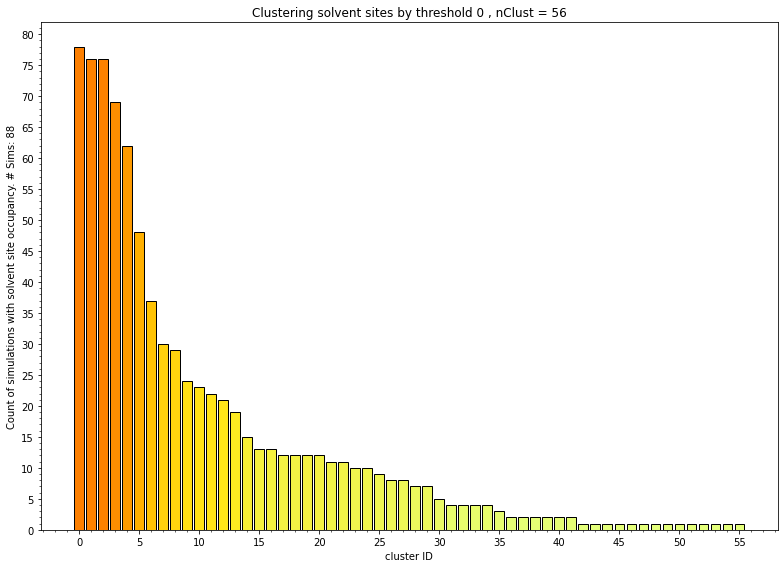

In [84]:
fig, axes = plt.subplots(nRow,nCol, figsize=sizeFigure)
for i in range(numList):
    jj = i % nCol ; ii = int(i / nCol)
    axThis = axes[ii,jj] if numList>1 else axes
    cMap = cm.get_cmap("Wistia")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    im = axThis.bar(range(len(listClustCounts[i])), listClustCounts[i], color=cMap(rescale(listClustCounts[i])), edgecolor='k')
    axThis.set_xlabel( 'cluster ID' ) ; axThis.set_ylabel( 'Count of simulations with solvent site occupancy. # Sims: %i' % numG )    
    axThis.xaxis.set_major_locator(ticker.MultipleLocator(5)) ; axThis.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axThis.yaxis.set_major_locator(ticker.MultipleLocator(5)) ; axThis.yaxis.set_minor_locator(ticker.MultipleLocator(1))       
    axThis.set_title('Clustering solvent sites by threshold %g , nClust = %i' % (1.0-listDistThres[i], len(listClustCounts[i])))
#plt.colorbar(im, ax=axThis)
plt.tight_layout()
plt.savefig('./solvent_mapping_cluster_counts.png')

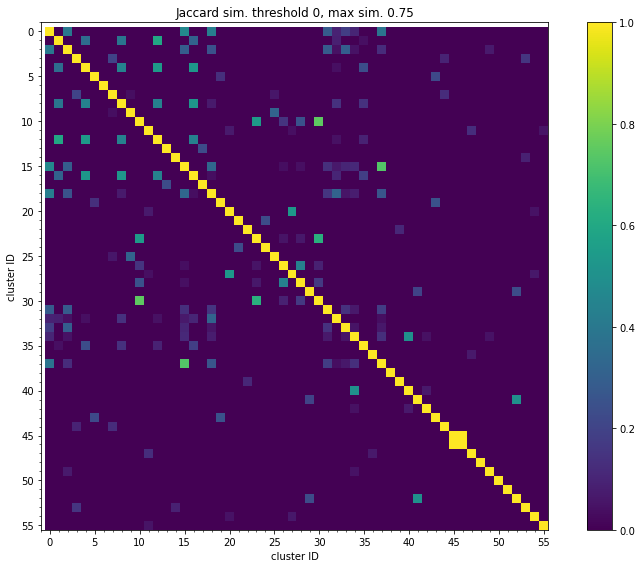

In [85]:
fig, axes = plt.subplots(nRow,nCol, figsize=sizeFigure)
for i in range(numList):
    jj = i % nCol ; ii = int(i / nCol)
    axThis = axes[ii,jj] if numList>1 else axes
    im = axThis.imshow(listMatDiff[i], cmap="viridis")    
    axThis.set_xlim( left=-1 ) ;  axThis.set_ylim( top=-1 )
    axThis.set_xlabel( 'cluster ID' ) ; axThis.set_ylabel( 'cluster ID' )
    axThis.xaxis.set_major_locator(ticker.MultipleLocator(5)) ; axThis.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    axThis.yaxis.set_major_locator(ticker.MultipleLocator(5)) ; axThis.yaxis.set_minor_locator(ticker.MultipleLocator(1))    
    maxVal=np.max( listMatDiff[i][np.where(listMatDiff[i]<1.0)] )
    axThis.set_title('Jaccard sim. threshold %g, max sim. %g' % (1.0-listDistThres[i], maxVal))
plt.colorbar(im, ax=axThis)
plt.tight_layout()
plt.savefig('./solvent_mapping_cluster_difference.png')

In [86]:
distThres=1.0
# = = Strategy: cluster this by agglomerative clustering
#connectivity = mapIntersects>0
clust = AgglomerativeClustering(n_clusters=None, affinity='precomputed', 
                                linkage='complete', distance_threshold=distThres)
clust.fit(1.0-mapIntersects)
clustIDs = renumber_clusterIDs_by_size(clust.labels_)
numClust = clust.n_clusters_

In [87]:
# = = = Add cluster information to graphs
for cID, graphID, key in zip( clustIDs, hostSolvents, nameSolvents):
    listG[ graphID ].nodes[key]['clusterID'] = cID

In [88]:
print( "= = Number of clusters:", clust.n_clusters_ )
#print( "= = Label array:", clust.labels_ )
listProtContactIntersections = []
listProtContactUnions = []
for i in range( numClust ):
    indices = np.where( clustIDs == i )[0]
    print("  ...clustID %i : %i members" % (i, len(indices)) )
    #print("  ", indices)
    if len(indices)>1:
        neighbourList=[]
        for j in indices:
            #eighbours= [ [n for n in nx.neighbors(listG[0], x)] for x in listG[0].solventIDs ]
            neighbourList.append( set(nx.neighbors( listG[hostSolvents[j]], nameSolvents[j] ) ) )
        #print( "...contacts:", neighbourList )           
        intersection = neighbourList.pop().intersection(*neighbourList)
        union = neighbourList.pop().union(*neighbourList)
        listProtContactIntersections.append( intersection )
        listProtContactUnions.append( union )
        print( convert_to_selection( intersection ) )
        print( convert_to_selection( union ) )        
    else:
        j=indices[0]
        s = set(nx.neighbors( listG[hostSolvents[j]], nameSolvents[j] ) ) 
        listProtContactIntersections.append( s )
        listProtContactUnions.append( s )
        print( "    ...contacts:", convert_to_selection(s) )
        #print( [ edge for edge in listG[ hostSolvents[j] ][ nameSolvents[j] ] ] )
    #The reference node: listG[ hostSolvents[i] ][ nameSolvents[i] ]


= = Number of clusters: 56
  ...clustID 0 : 78 members
protein and resid 573 603 464 465 572
protein and resid 573 603 464 465 572 1348 493
  ...clustID 1 : 76 members
protein and resid 549 1251 550
protein and resid 1370 549 551 1371 553 548 1251 550 1291
  ...clustID 2 : 76 members
protein and resid 465
protein and resid 1344 465 1347 572 1348 493 494
  ...clustID 3 : 69 members
protein and resid 28 1032 1036 1033 24
protein and resid 1037 1032 1036 27 24 28 1034 1033 1035 25
  ...clustID 4 : 62 members
protein and resid 1400
protein and resid 1370 1401 1371 1250 1402 1254 1400 1251 550 1291
  ...clustID 5 : 48 members
protein and resid 944 988 945 852 941
protein and resid 945 852 988 944 942 987 983 948 941
  ...clustID 6 : 37 members
protein and resid 210 206 93 207 89
protein and resid 210 203 206 93 207 89
  ...clustID 7 : 30 members
protein and resid 1033
protein and resid 1037 1095 1092 1036 1096 1091 1033 1040
  ...clustID 8 : 29 members
protein and resid
protein and resid 13

In [73]:
for i in range(numG):
    if 'D513' in listG[i].source:
        print( i, listG[i].source )

73 ./trajectories/D513G/310K/1/contactPairs_SOL.txt
74 ./trajectories/D513G/310K/2/contactPairs_SOL.txt
75 ./trajectories/D513G/310K/3/contactPairs_SOL.txt


In [74]:
for i in [29,30,31,32,33,34,52,53,54,55,56,57,58,59,60]:
    print(listG[i].source)
    print("Cluster waters:", [b for a,b in listG[i].nodes(data='clusterID', default=-1) if b>=0] )

./trajectories/R31C/310K/2/contactPairs_SOL.txt
Cluster waters: [8, 1, 2, 0, 10, 9, 5, 19, 44]
./trajectories/R31C/310K/3/contactPairs_SOL.txt
Cluster waters: [4, 1, 15, 31, 18, 9, 5, 3, 6, 22, 24, 23]
./trajectories/D836Y/310K/1/contactPairs_SOL.txt
Cluster waters: [1, 0, 4, 2, 3, 9, 45, 46, 13, 25]
./trajectories/D836Y/310K/2/contactPairs_SOL.txt
Cluster waters: [3, 4, 5, 1, 2, 0, 6, 9, 13]
./trajectories/D836Y/310K/3/contactPairs_SOL.txt
Cluster waters: [1, 8, 2, 0, 5, 25, 3, 17, 24, 9, 10]
./trajectories/E826K/310K/1/contactPairs_SOL.txt
Cluster waters: [1, 4, 3, 5, 0, 2, 9, 6, 33, 21]
./trajectories/Q1291F/310K/1/contactPairs_SOL.txt
Cluster waters: [8, 3, 4, 12, 2, 0, 16, 7, 6]
./trajectories/Q1291F/310K/2/contactPairs_SOL.txt
Cluster waters: [4, 1, 8, 5, 2, 0, 10, 22, 3]
./trajectories/Q1291F/310K/3/contactPairs_SOL.txt
Cluster waters: [3, 4, 12, 2, 10, 0, 1, 5, 27, 17, 20, 7, 6, 9, 25, 19]
./trajectories/Q1291H/310K/1/contactPairs_SOL.txt
Cluster waters: [4, 1, 0, 2, 9, 25, 6]


In [75]:
# = = = Write Tcl renumbering module
def format_solvent_indices_VMD(G):
    out=""
    for k in G.solventIDs:
        out+=" %s" % k.split("_")[-1]
    return out

def format_cluster_indices_VMD(G, offset=0):
    out=""
    for k in G.solventIDs:
        out+=" %s" % str(G.nodes[k]['clusterID']+offset)
    return out

def export_tcl_psf_editor(fileName, listG):
    sourceTOP='seg.psf' ; sourceTRJ='sum.xtc' ; outTOP='segRenum.psf'
    newSegName='CRY'
    fp = open(fileName,'w')
    for G in listG:
        sourceFolder=os.path.dirname(G.source)
        print("set m [mol new %s waitfor all]" % os.path.join(sourceFolder, sourceTOP), file=fp )
        print("set indexList [list %s]" % format_solvent_indices_VMD(G), file=fp)
        print("set residList [list %s]" % format_cluster_indices_VMD(G), file=fp)        
        print("foreach i $indexList r $residList {", file=fp)
        print('    set selSolv [atomselect $m "same residue as index $i"]', file=fp)
        print('    $selSolv set segname %s' % newSegName, file=fp)
        print('    $selSolv set resid $r', file=fp)
        print('    $selSolv delete', file=fp)
        print('}', file=fp)
        print('animate dup $m', file=fp)
        print('animate write psf %s waitfor all $m' % os.path.join(sourceFolder, outTOP), file=fp)
        print('mol delete $m', file=fp)
        print('', file=fp)
        #print('delete $m')
    print('exit', file=fp)

In [76]:
export_tcl_psf_editor('./Stable_Solvent_Clustering.rename_solvents.tcl', listG)

In [77]:
def export_cluster_residue_definitions(fileName, intersects, unions):
    nSet = len(intersects)
    fp = open(fileName, 'w')
    for i in range(nSet):
        print("%i Intersection:" % i, file=fp, end=' ')
        print(*(intersects[i]), file=fp)
        print("%i Union:" % i, file=fp, end=' ')
        print(*(unions[i]), file=fp)

In [78]:
export_cluster_residue_definitions('./Stable_Solvent_Clustering.cluster_definitions.txt', listProtContactIntersections, listProtContactUnions)